# AAI-540 Group 6 Final Project

Authors: Alden Caterio, Gary Takahashi, Paul Parks

In [2]:
%pip install --disable-pip-version-check -q PyAthena
%pip install --disable-pip-version-check -q awswrangler
%pip install -q wordcloud
%pip install -q -U seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Imports

In [3]:
import os
import pandas as pd
import numpy as np
import boto3
from sagemaker.session import Session
from sagemaker.feature_store.feature_group import FeatureGroup
from sagemaker import get_execution_role
from time import gmtime, strftime, time
from botocore.client import ClientError
from pyathena import connect
import pandas as pd
import boto3
import sagemaker
import awswrangler as wr
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


## AWS S3 and Athena Setup

### Collect a raw data set and store it in an S3 Datalake.

In [4]:
session = boto3.session.Session()
region = session.region_name
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()

s3 = boto3.Session().client(service_name="s3", region_name=region)

print("Default bucket: {}".format(bucket))

Default bucket: sagemaker-us-east-1-048586998276


In [5]:
response = None
try:
    response = s3.head_bucket(Bucket=bucket)
    print(response)
    setup_s3_bucket_passed = True
except ClientError as e:
    print("[ERROR] Cannot find bucket {} in {} due to {}.".format(bucket, response, e))

{'ResponseMetadata': {'RequestId': 'DH6BAXW2ZX756CNZ', 'HostId': 'U/bPQOTJ5VfNFCLnSvmN+dmK5KlQOPZp6pMm+rcW7uzGsCH1UhGnlGirii1GCd6NK2eHAq0J38I=', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amz-id-2': 'U/bPQOTJ5VfNFCLnSvmN+dmK5KlQOPZp6pMm+rcW7uzGsCH1UhGnlGirii1GCd6NK2eHAq0J38I=', 'x-amz-request-id': 'DH6BAXW2ZX756CNZ', 'date': 'Sun, 20 Oct 2024 23:22:25 GMT', 'x-amz-bucket-region': 'us-east-1', 'x-amz-access-point-alias': 'false', 'content-type': 'application/xml', 'server': 'AmazonS3'}, 'RetryAttempts': 0}, 'BucketRegion': 'us-east-1', 'AccessPointAlias': False}


In [6]:
filename = 'CEAS_08.csv'
#local_csv_path = './dataset/' + filename
local_csv_path = 'dataset/CEAS_08.csv'

parquet_filename = filename.replace('.csv', '.parquet')  # Parquet file name
local_parquet_path = os.path.join('./dataset/', parquet_filename)

df = pd.read_csv(local_csv_path)
# Convert the CSV to Parquet
df['urls'] = df['urls'].astype(str)
df['label'] = df['label'].astype(int)  # Convert 'label' column to integer
df = df.drop(["receiver","date","urls"], axis=1)
df.to_parquet(local_parquet_path, engine='pyarrow')

folder_in_s3 = 'Dataset/'
s3_destination_path = f's3://{bucket}/{folder_in_s3}{parquet_filename}'
s3_destination_dir = f's3://{bucket}/{folder_in_s3}'

s3 = boto3.client('s3')

bucket_name = bucket
key = f'{folder_in_s3}{parquet_filename}'

s3.upload_file(local_parquet_path, bucket_name, key)

response = s3.list_objects_v2(Bucket=bucket_name, Prefix=key)
if 'Contents' in response:
    print(f"File '{local_parquet_path}' uploaded successfully to '{s3_destination_path}'")
else:
    print(f"Failed to upload file to {s3_destination_path}")

File './dataset/CEAS_08.parquet' uploaded successfully to 's3://sagemaker-us-east-1-048586998276/Dataset/CEAS_08.parquet'


In [7]:
df.head()

,sender,subject,body,label
0,Young Esposito <Young@iworld.de>,Never agree to be a loser,"Buck up, your troubles caused by small dimensi...",1
1,Mok <ipline's1983@icable.ph>,Befriend Jenna Jameson,\nUpgrade your sex and pleasures with these te...,1
2,Daily Top 10 <Karmandeep-opengevl@universalnet...,CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1
3,Michael Parker <ivqrnai@pobox.com>,Re: svn commit: r619753 - in /spamassassin/tru...,Would anyone object to removing .so from this ...,0
4,Gretchen Suggs <externalsep1@loanofficertool.com>,SpecialPricesPharmMoreinfo,\nWelcomeFastShippingCustomerSupport\nhttp://7...,1


### Set up Athena tables to enable cataloging and querying of your data.

In [8]:
database_name = "spam_detection_db"
s3_staging_dir = "s3://{0}/athena/staging".format(bucket)

conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)
statement = "CREATE DATABASE IF NOT EXISTS {}".format(database_name)

pd.read_sql(statement, conn)

/tmp/ipykernel_58/4249963361.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql(statement, conn)


""


In [9]:
statement = "SHOW DATABASES"
df_show = pd.read_sql(statement, conn)
df_show.head(5)

/tmp/ipykernel_58/1677879827.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_show = pd.read_sql(statement, conn)


,database_name
0,default
1,dsoaws
2,sagemaker_featurestore
3,spam_detection_db


In [10]:
table_name = "emails"
statement = f"""DROP TABLE IF EXISTS {database_name}.{table_name}"""
pd.read_sql(statement, conn)

/tmp/ipykernel_58/3526594799.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql(statement, conn)


""


In [11]:
database_name = 'spam_detection_db'
table_name = 'emails'
# Alden: Had to change this for my account; might need to change this if you want to run this cell on your account
# s3_location = 's3://sagemaker-us-east-1-019877554860/Dataset'
s3_location = 's3://sagemaker-us-east-1-048586998276/Dataset'

statement = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {database_name}.{table_name}
(
    sender STRING,
    subject STRING,
    body STRING,
    label INT
)
STORED AS PARQUET
LOCATION '{s3_location}'
"""

pd.read_sql(statement, conn)

/tmp/ipykernel_58/2458618226.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql(statement, conn)


""


In [12]:
statement = f"SHOW TABLES in {database_name}"

df_show = pd.read_sql(statement, conn)
print(df_show.head(5))

if table_name in df_show.values:
    print("[OK] Table created successfully.")
else:
    print("[ERROR] Table creation failed.")

/tmp/ipykernel_58/1698154721.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_show = pd.read_sql(statement, conn)


  tab_name
0   emails
[OK] Table created successfully.


In [13]:
statement = f"""SELECT COUNT(*) AS total_rows
FROM {database_name}.{table_name}"""

result = pd.read_sql(statement, conn)
result.head(5)

/tmp/ipykernel_58/1710626760.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result = pd.read_sql(statement, conn)


,total_rows
0,39154


In [14]:
statement = f"""SELECT * FROM {database_name}.{table_name} LIMIT 10"""

result = pd.read_sql(statement, conn)
result.head(10)

/tmp/ipykernel_58/1869399943.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result = pd.read_sql(statement, conn)


,sender,subject,body,label
0,Young Esposito <Young@iworld.de>,Never agree to be a loser,"Buck up, your troubles caused by small dimensi...",1
1,Mok <ipline's1983@icable.ph>,Befriend Jenna Jameson,\nUpgrade your sex and pleasures with these te...,1
2,Daily Top 10 <Karmandeep-opengevl@universalnet...,CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1
3,Michael Parker <ivqrnai@pobox.com>,Re: svn commit: r619753 - in /spamassassin/tru...,Would anyone object to removing .so from this ...,0
4,Gretchen Suggs <externalsep1@loanofficertool.com>,SpecialPricesPharmMoreinfo,\nWelcomeFastShippingCustomerSupport\nhttp://7...,1
5,Caroline Aragon <dwthaidomainnamesm@thaidomain...,From Caroline Aragon,\n\n\n\n\nYo wu urS mo ou go rc ebo eForM rgi ...,1
6,Replica Watches <jhorton@thebakercompanies.com>,Replica Watches,We have fake Swiss Men's and Ladie's Replica \...,1
7,Daily Top 10 <acidirev_1972@tcwpg.com>,CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1
8,qydlqcws-iacfym@issues.apache.org,[Bug 5780] URI processing turns uuencoded stri...,http://issues.apache.org/SpamAssassin/show_bug...,0
9,Daily Top 10 <orn|dent_1973@musicaedischi.it>,CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1


## AWS FeatureStore

### Test Train Split
Split your feature data into training (~40%), test (~10%) validation (~10%) datasets.
Reserve some data for “production data” (~40%).

In [15]:
feature_store_data = wr.athena.read_sql_query(f"SELECT * FROM {database_name}.{table_name}", database=database_name)

In [16]:
# Set up AWS clients and SageMaker session
boto_session = boto3.Session()
region = boto_session.region_name
sagemaker_client = boto_session.client(service_name="sagemaker", region_name=region)
featurestore_runtime = boto_session.client(service_name="sagemaker-featurestore-runtime", region_name=region)
feature_store_session = Session(boto_session=boto_session, sagemaker_client=sagemaker_client, sagemaker_featurestore_runtime_client=featurestore_runtime)

# Define the S3 bucket for the offline store
default_s3_bucket_name = feature_store_session.default_bucket()
prefix = "sagemaker-featurestore-spamdetection"

# Set up IAM role for SageMaker
role = get_execution_role()

In [17]:
# Create a FeatureGroup for the data
spamdetection_feature_group_name = "spamdetection-feature-group" + strftime("%d-%H-%M-%S", gmtime())
spamdetection_feature_group = FeatureGroup(name=spamdetection_feature_group_name, sagemaker_session=feature_store_session)

# Cast necessary columns to the right types
def cast_object_to_string(data_frame):
    for label in data_frame.columns:
        if data_frame.dtypes[label] == "object":
            data_frame[label] = data_frame[label].astype("str").astype("string")

cast_object_to_string(feature_store_data)

In [18]:
from time import sleep
import uuid
current_time_sec = int(time())

feature_store_data['primary_key'] = [str(uuid.uuid4()) for _ in range(len(feature_store_data))]
feature_store_data['event_time'] = pd.Series([current_time_sec] * len(feature_store_data), dtype='float64')

# Record identifier and event time feature names
record_identifier_feature_name = 'primary_key'
event_time_feature_name = 'event_time'

# Load feature definitions from the DataFrame
spamdetection_feature_group.load_feature_definitions(data_frame=feature_store_data)

# Create the FeatureGroup in the SageMaker FeatureStore
spamdetection_feature_group.create(
    s3_uri=f"s3://{default_s3_bucket_name}/{prefix}",
    record_identifier_name=record_identifier_feature_name,
    event_time_feature_name=event_time_feature_name,
    role_arn=role,
    enable_online_store=True,
)


# Wait for the FeatureGroup to be created
def wait_for_feature_group_creation_complete(feature_group):
    status = feature_group.describe().get("FeatureGroupStatus")
    while status == "Creating":
        print("Waiting for Feature Group Creation")
        sleep(5)
        status = feature_group.describe().get("FeatureGroupStatus")
    if status != "Created":
        raise RuntimeError(f"Failed to create feature group {feature_group.name}")
    print(f"FeatureGroup {feature_group.name} successfully created.")

wait_for_feature_group_creation_complete(feature_group=spamdetection_feature_group)

Waiting for Feature Group Creation
Waiting for Feature Group Creation
Waiting for Feature Group Creation
Waiting for Feature Group Creation
Waiting for Feature Group Creation
Waiting for Feature Group Creation
FeatureGroup spamdetection-feature-group20-23-22-44 successfully created.


## Exploratory Data Analysis

In [19]:
df = feature_store_data

In [20]:
# Display the first few rows of the dataset
df.head()

,sender,subject,body,label,primary_key,event_time
0,Young Esposito <Young@iworld.de>,Never agree to be a loser,"Buck up, your troubles caused by small dimensi...",1,b98e517b-282c-44d2-b163-979ad14ab418,1.729467e+09
1,Michael Parker <ivqrnai@pobox.com>,Re: svn commit: r619753 - in /spamassassin/tru...,Would anyone object to removing .so from this ...,0,3b8670cc-550c-473b-baba-3dc172e95096,1.729467e+09
2,Gretchen Suggs <externalsep1@loanofficertool.com>,SpecialPricesPharmMoreinfo,WelcomeFastShippingCustomerSupport http://7iw...,1,6f01b22d-ef56-4a98-a651-3c8c9743fb8f,1.729467e+09
3,Caroline Aragon <dwthaidomainnamesm@thaidomain...,From Caroline Aragon,Yo wu urS mo ou go rc ebo eForM rgi oreWo...,1,f4ba3531-d1a4-467d-9072-eb6517bcbbf2,1.729467e+09
4,Replica Watches <jhorton@thebakercompanies.com>,Replica Watches,We have fake Swiss Men's and Ladie's Replica ...,1,6ed230cb-120d-48c4-978c-147f2e784cc0,1.729467e+09


In [21]:
# Get the shape of the dataset (number of rows and columns)
print(f"Dataset contains {df.shape[0]} rows and {df.shape[1]} columns.")

Dataset contains 39154 rows and 6 columns.


In [22]:
# Get information about data types and non-null counts
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39154 entries, 0 to 39153
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   sender       39154 non-null  string 
 1   subject      39126 non-null  string 
 2   body         39154 non-null  string 
 3   label        39154 non-null  Int32  
 4   primary_key  39154 non-null  object 
 5   event_time   39154 non-null  float64
dtypes: Int32(1), float64(1), object(1), string(3)
memory usage: 1.7+ MB


In [23]:
# Get statistical summary of numerical columns
df.describe()

,label,event_time
count,39154.0,3.915400e+04
mean,0.557848,1.729467e+09
std,0.496649,0.000000e+00
min,0.0,1.729467e+09
25%,0.0,1.729467e+09
50%,1.0,1.729467e+09
75%,1.0,1.729467e+09
max,1.0,1.729467e+09


In [24]:
# Check for missing values in each column
missing_values = df.isnull().sum()
print("Missing values in each column:")
print(missing_values)

Missing values in each column:
sender          0
subject        28
body            0
label           0
primary_key     0
event_time      0
dtype: int64


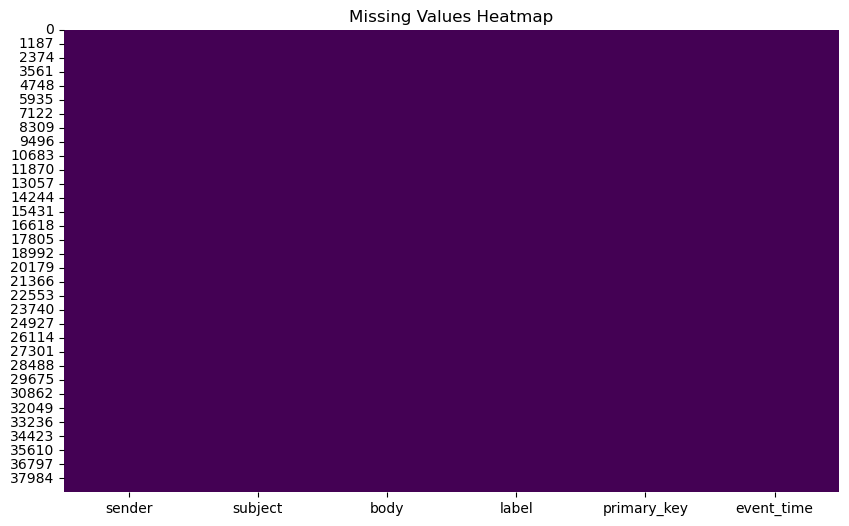

In [25]:
# Visualize missing values using a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

In [26]:
# Get the distribution of the target variable 'label'
label_counts = df['label'].value_counts()
print("Distribution of target variable 'label':")
print(label_counts)

Distribution of target variable 'label':
label
1    21842
0    17312
Name: count, dtype: Int64


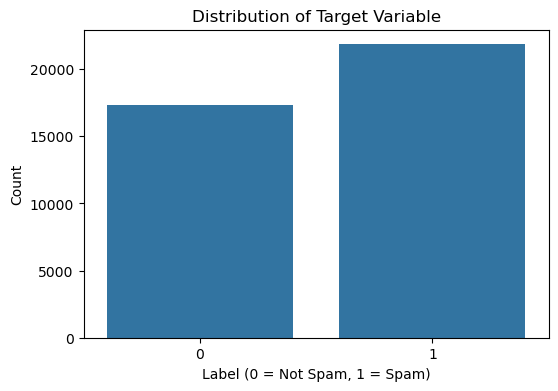

In [27]:
# Visualize the distribution of the target variable
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=df)
plt.title('Distribution of Target Variable')
plt.xlabel('Label (0 = Not Spam, 1 = Spam)')
plt.ylabel('Count')
plt.show()

In [28]:
# Check the number of unique senders and receivers
num_senders = df['sender'].nunique()
print(f"Number of unique senders: {num_senders}")

Number of unique senders: 24578


In [29]:
# Top 10 most frequent senders
top_senders = df['sender'].value_counts().head(10)
print("Top 10 senders:")
print(top_senders)

Top 10 senders:
sender
qydlqcws-iacfym@issues.apache.org                 462
Guido van Rossum <hoauf@python.org>               295
"\\"Martin v. Löwis\\"" <qpnysl@v.loewis.de>      276
"Carlos E. R." <vyjwd.trpcau@telefonica.net>      208
Aaron Kulkis <cmiqlkx91@hotpop.com>               183
Rafael Garcia-Suarez <pvhuhqgncrxnu@gmail.com>    158
Christian Heimes <wluhe@cheimes.de>               152
Barry Warsaw <pjaxq@python.org>                   131
iybz@pobox.com                                    124
Per Jessen <uee@computer.org>                     113
Name: count, dtype: Int64


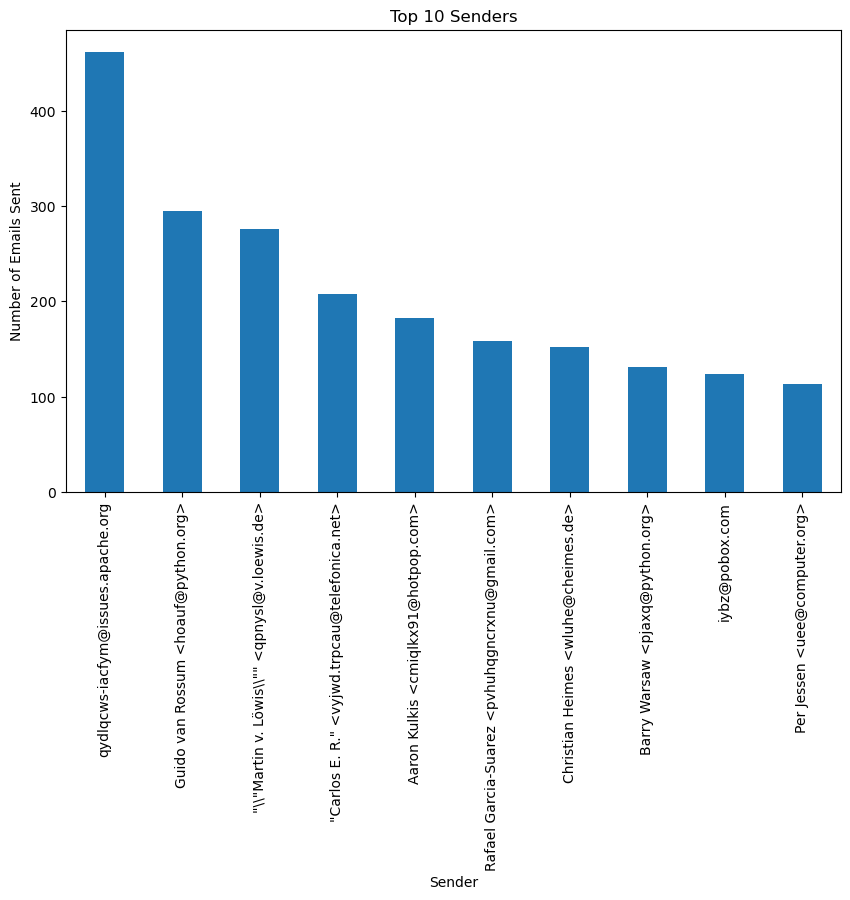

In [30]:
# Visualize top senders
plt.figure(figsize=(10, 6))
top_senders.plot(kind='bar')
plt.title('Top 10 Senders')
plt.xlabel('Sender')
plt.ylabel('Number of Emails Sent')
plt.show()

In [31]:
# Create new features for the lengths of text fields
df['subject_length'] = df['subject'].astype(str).apply(len)
df['body_length'] = df['body'].astype(str).apply(len)

In [32]:
# Statistical summary of the text lengths
text_length_summary = df[['subject_length', 'body_length']].describe()
print("Statistical summary of text lengths:")
print(text_length_summary)

Statistical summary of text lengths:
       subject_length    body_length
count    39154.000000   39154.000000
mean        38.899397    1571.079813
std         20.764513    3615.810576
min          1.000000      14.000000
25%         25.000000     224.000000
50%         35.000000     570.000000
75%         50.000000    1643.000000
max        285.000000  143996.000000


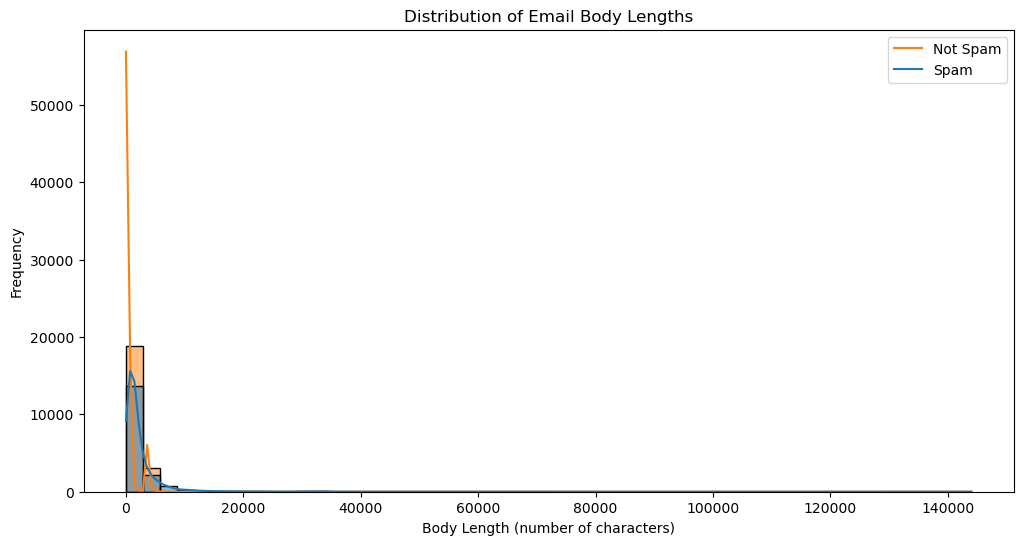

In [33]:
# Visualize the distribution of body lengths for spam and non-spam emails
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='body_length', hue='label', bins=50, kde=True)
plt.title('Distribution of Email Body Lengths')
plt.xlabel('Body Length (number of characters)')
plt.ylabel('Frequency')
plt.legend(labels=['Not Spam', 'Spam'])
plt.show()

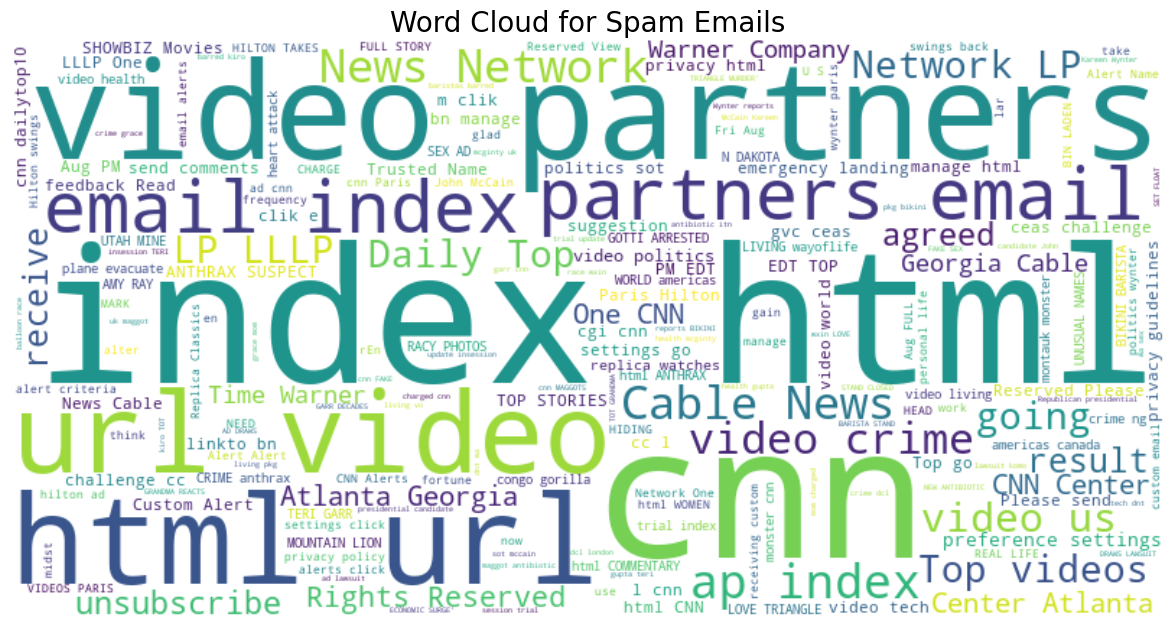

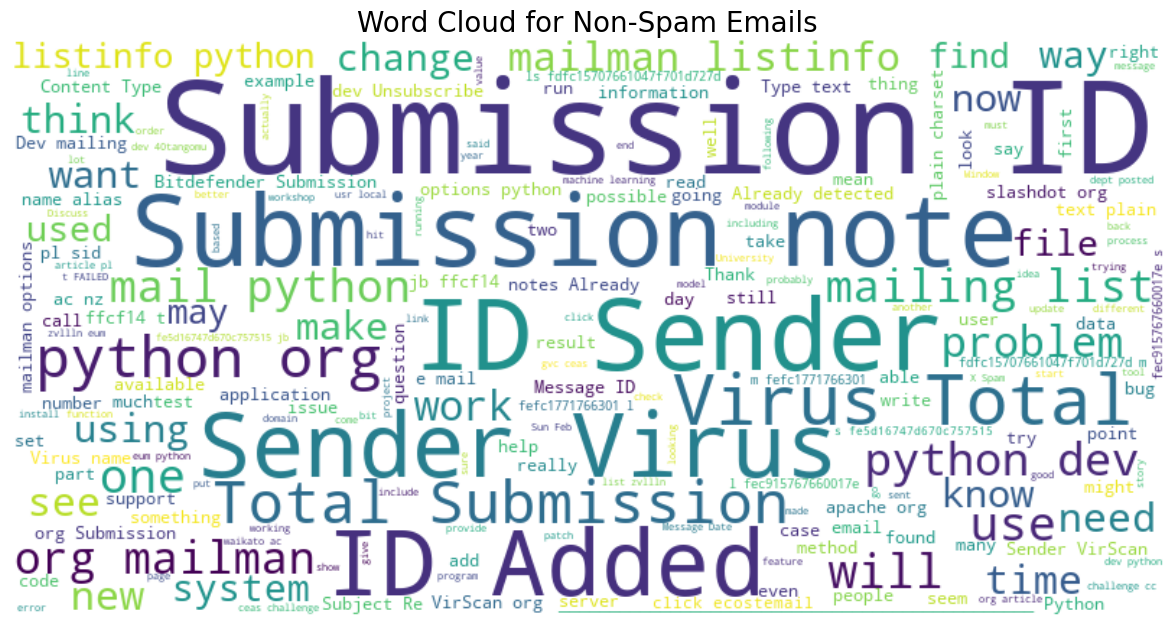

In [34]:
# Generate word clouds for spam and non-spam emails
spam_emails = df[df['label'] == 1]
non_spam_emails = df[df['label'] == 0]

def generate_wordcloud(text_data, title):
    text = ' '.join(text_data.dropna().astype(str))
    wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=STOPWORDS).generate(text)
    plt.figure(figsize=(15, 7.5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=20)
    plt.show()

# Word cloud for spam emails
generate_wordcloud(spam_emails['body'], 'Word Cloud for Spam Emails')

# Word cloud for non-spam emails
generate_wordcloud(non_spam_emails['body'], 'Word Cloud for Non-Spam Emails')

In [35]:
# Create a DataFrame with numerical features
numerical_features = ['subject_length', 'body_length']
numerical_df = df[numerical_features + ['label']]

# Compute the correlation matrix
correlation_matrix = numerical_df.corr()

print("Correlation matrix:")
print(correlation_matrix)

Correlation matrix:
                subject_length  body_length     label
subject_length        1.000000     0.063805 -0.393957
body_length           0.063805     1.000000 -0.239108
label                -0.393957    -0.239108  1.000000


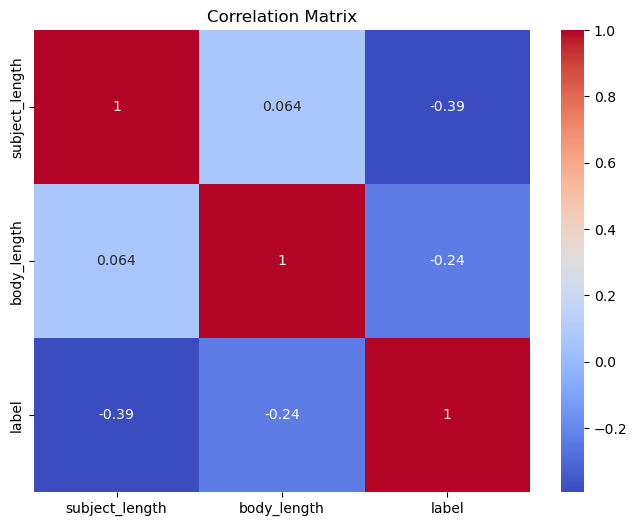

In [36]:
# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

## Model

In [37]:
# keep the original dataset untampered
# only using 10000 rows for now because kernel keeps crashing
df_new = df

# Combine subject and body
df_new['text'] = df_new['subject'] + ' ' + df_new['body']

In [38]:
df_new.head()

,sender,subject,body,label,primary_key,event_time,subject_length,body_length,text
0,Young Esposito <Young@iworld.de>,Never agree to be a loser,"Buck up, your troubles caused by small dimensi...",1,b98e517b-282c-44d2-b163-979ad14ab418,1.729467e+09,25,273,"Never agree to be a loser Buck up, your troubl..."
1,Michael Parker <ivqrnai@pobox.com>,Re: svn commit: r619753 - in /spamassassin/tru...,Would anyone object to removing .so from this ...,0,3b8670cc-550c-473b-baba-3dc172e95096,1.729467e+09,150,24418,Re: svn commit: r619753 - in /spamassassin/tru...
2,Gretchen Suggs <externalsep1@loanofficertool.com>,SpecialPricesPharmMoreinfo,WelcomeFastShippingCustomerSupport http://7iw...,1,6f01b22d-ef56-4a98-a651-3c8c9743fb8f,1.729467e+09,26,175,SpecialPricesPharmMoreinfo WelcomeFastShippin...
3,Caroline Aragon <dwthaidomainnamesm@thaidomain...,From Caroline Aragon,Yo wu urS mo ou go rc ebo eForM rgi oreWo...,1,f4ba3531-d1a4-467d-9072-eb6517bcbbf2,1.729467e+09,20,93,From Caroline Aragon Yo wu urS mo ou go r...
4,Replica Watches <jhorton@thebakercompanies.com>,Replica Watches,We have fake Swiss Men's and Ladie's Replica ...,1,6ed230cb-120d-48c4-978c-147f2e784cc0,1.729467e+09,15,115,Replica Watches We have fake Swiss Men's and L...


In [39]:
# Splitting 75% for training, 10% for testing, 10% for validation, 5% for synthetic data for monitoring
# df_new -> 25% production, 75% train
df_production, df_train = train_test_split(df_new, test_size=0.75, random_state=42)
# production -> 15% production_2, 10% test
df_production_2, df_test = train_test_split(df_production, test_size=0.40, random_state=42)
# production_2 -> 5% synthetic data, 10% validation
df_synth, df_validation = train_test_split(df_production_2, test_size=0.66, random_state=42)

# Print the sizes of each split to confirm
print(f"Number of total rows in original dataset: {len(df_new)} rows")
print(f"Training data: {len(df_train)} rows")
print(f"Test data: {len(df_test)} rows")
print(f"Validation data: {len(df_validation)} rows")
print(f"Synthetic data: {len(df_synth)} rows")
# print(f"Production data: {len(df_production)} rows")

Number of total rows in original dataset: 39154 rows
Training data: 29366 rows
Test data: 3916 rows
Validation data: 3876 rows
Synthetic data: 1996 rows


In [40]:
# Save the training data to CSV
df_train[['label', 'text']].to_csv('train.csv', index=False)

sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()

prefix = 'benchmark-model'

train_input_path = sagemaker_session.upload_data('train.csv', bucket=bucket, key_prefix=f'{prefix}/train')

print(f'Training data uploaded to: {train_input_path}')

Training data uploaded to: s3://sagemaker-us-east-1-048586998276/benchmark-model/train/train.csv


### Train script
the following script will be output and used by the estimator

In [41]:
%%writefile train.py

import argparse
import os
import pandas as pd
import joblib

from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import TfidfVectorizer

def model_fn(model_dir):
    """Load the model for inference"""
    model = joblib.load(os.path.join(model_dir, "model.joblib"))
    vectorizer = joblib.load(os.path.join(model_dir, "vectorizer.joblib"))
    return model, vectorizer

def predict_fn(input_data, model_and_vectorizer):
    """Vectorize string input and make predictions"""
    model, vectorizer = model_and_vectorizer
    
    # Check if the input data is a string (email body)
    # Transform the input string to TF-IDF features
    input_tfidf = vectorizer.transform([str(input_data)])
    input_dense = input_tfidf.toarray()  # Convert to dense format for GaussianNB

    # Make predictions using the trained model
    prediction = model.predict(input_dense)
    
    return prediction

if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    
    # SageMaker-specific arguments
    parser.add_argument('--model-dir', type=str, default=os.environ.get('SM_MODEL_DIR'))
    parser.add_argument('--train', type=str, default=os.environ.get('SM_CHANNEL_TRAIN'))
    
    args = parser.parse_args()
    
    # Read the training data
    train_data = pd.read_csv(os.path.join(args.train, 'train.csv'))
    
    # Separate features and target
    X_train = train_data['text'].astype(str)
    y_train = train_data['label']
    
    # Create the TF-IDF vectorizer
    vectorizer = TfidfVectorizer(max_features=10000)    
    X_train_tfidf = vectorizer.fit_transform(X_train)
   
    # Convert sparse matrix to dense for GaussianNB
    X_train_dense = X_train_tfidf.toarray()
    
    # Train the model
    # Build a Naive Bayes Classifier
    model = GaussianNB()
    
    model.fit(X_train_dense, y_train)
    
    # Save the model
    joblib.dump(model, os.path.join(args.model_dir, "model.joblib"))
    joblib.dump(vectorizer, os.path.join(args.model_dir, "vectorizer.joblib"))


Overwriting train.py


### Train the model

In [42]:
from sagemaker.sklearn.estimator import SKLearn

role = sagemaker.get_execution_role()

sklearn_estimator = SKLearn(
    entry_point='train.py',
    role=role,
    instance_count=1,
    instance_type='ml.m5.xlarge',
    framework_version='0.23-1',
    py_version='py3',
    output_path=f's3://{bucket}/{prefix}/output'
)

# Run the training job
sklearn_estimator.fit({'train': train_input_path})

INFO:sagemaker:Creating training-job with name: sagemaker-scikit-learn-2024-10-20-23-24-06-960


2024-10-20 23:24:07 Starting - Starting the training job...
2024-10-20 23:24:22 Starting - Preparing the instances for training...
2024-10-20 23:25:00 Downloading - Downloading input data...
2024-10-20 23:25:25 Downloading - Downloading the training image...
2024-10-20 23:25:51 Training - Training image download completed. Training in progress..2024-10-20 23:26:02,103 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2024-10-20 23:26:02,105 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-10-20 23:26:02,146 sagemaker_sklearn_container.training INFO     Invoking user training script.
2024-10-20 23:26:02,312 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-10-20 23:26:02,324 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-10-20 23:26:02,335 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-10-20 23:

## Deploy the trained model

In [43]:
from datetime import datetime, timedelta, timezone
from sagemaker.model_monitor import DataCaptureConfig

prefix_2 = "sagemaker/Churn-ModelQualityMonitor-20201201"
data_capture_prefix = f"{prefix}/datacapture"
s3_capture_upload_path = f"s3://{bucket}/{data_capture_prefix}"

# define data capture configuration details
data_capture_config = DataCaptureConfig(
    enable_capture=True, sampling_percentage=100, destination_s3_uri=s3_capture_upload_path
)

# define endpoint name
endpoint_name = f"naivebayes-spam-detection-model-quality-monitor-{datetime.utcnow():%Y-%m-%d-%H%M}"
print("EndpointName =", endpoint_name)

EndpointName = naivebayes-spam-detection-model-quality-monitor-2024-10-20-2326


In [44]:
# Deploy the model to an endpoint
predictor = sklearn_estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.xlarge',
    endpoint_name=endpoint_name,   # Adding endpoint name for model monitoring purposes
    data_capture_config=data_capture_config,
)

INFO:sagemaker:Creating model with name: sagemaker-scikit-learn-2024-10-20-23-26-49-099
INFO:sagemaker:Creating endpoint-config with name naivebayes-spam-detection-model-quality-monitor-2024-10-20-2326
INFO:sagemaker:Creating endpoint with name naivebayes-spam-detection-model-quality-monitor-2024-10-20-2326


------!

### Test Inference

In [45]:
test_email_subject = "Test Email"
test_email_body = "Hi this is not spam I promise"
test_email = test_email_subject + ' ' + test_email_body
print(predictor.predict(str(test_email)))

[1]


In [46]:
test_email_subject = "Project docs"
test_email_body = "I will send you the project doc later today"
test_email = test_email_subject + ' ' + test_email_body
print(predictor.predict(str(test_email)))

[0]


### Run inference for evaluation

In [47]:
# Prepare test data
df_test.dropna(inplace=True)
X_test = df_test['text']
y_test = df_test['label']

In [48]:
# Set the serializer and deserializer
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

# Make predictions
predicted_labels = []
for email_body in X_test:
    prediction = predictor.predict(str(email_body))
    predicted_labels.append(int(prediction[0]))

# Compare predictions with actual labels
print(predicted_labels[0:20])

[1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0]


## Evaluation

In [49]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, predicted_labels)
precision = precision_score(y_test, predicted_labels)
recall = recall_score(y_test, predicted_labels)
f1 = f1_score(y_test, predicted_labels)

print("Benchmark Model Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Benchmark Model Performance:
Accuracy: 0.9811
Precision: 0.9972
Recall: 0.9687
F1 Score: 0.9827


## Monitoring

In [50]:
df_validation.head()

,sender,subject,body,label,primary_key,event_time,subject_length,body_length,text
4298,happybrowndog <lujnfuahsrekm@hotmail.com>,[python-win32] Is Mark Hammond going to produc...,I've had Mark's Python Programming on Win32 bo...,0,f7d78c68-7a65-431f-a781-07234c756d4d,1.729467e+09,87,954,[python-win32] Is Mark Hammond going to produc...
24262,Tim Golden <cggc@timgolden.me.uk>,Re: [Python-Dev] fixing tests on windows,Trent Nelson wrote: > >> -----Original Messag...,0,23819446-a6de-4054-8660-e1e0582f5e74,1.729467e+09,40,2806,Re: [Python-Dev] fixing tests on windows Trent...
28527,Marcel Hutchinson <MarcelabsorptiveTrevino@cam...,Relax. Take a Deep Breath We have the answers ...,"Size DOES matter, and unfortunately, many tra...",1,329b65be-b87e-4723-8567-b227a58298af,1.729467e+09,55,216,Relax. Take a Deep Breath We have the answers ...
6937,Charlotte Correa <psmotolese@lucent.com>,Won't forget last night,The way to yoke the forces of nature There are...,1,caf99bbd-4a20-4bc7-8f01-663603fb28c7,1.729467e+09,23,367,Won't forget last night The way to yoke the fo...
13422,Daily Top 10 <selfintr@lesea.com>,CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1,95a579d6-6328-4f95-b8a5-1a58087297c7,1.729467e+09,20,3898,CNN.com Daily Top 10 >+=+=+=+=+=+=+=+=+=+=+=+=...


The feature "label" is the prediction feature.

In [51]:
df_validation_new = df_validation[['text','label']]
df_validation_new.head()

,text,label
4298,[python-win32] Is Mark Hammond going to produc...,0
24262,Re: [Python-Dev] fixing tests on windows Trent...,0
28527,Relax. Take a Deep Breath We have the answers ...,1
6937,Won't forget last night The way to yoke the fo...,1
13422,CNN.com Daily Top 10 >+=+=+=+=+=+=+=+=+=+=+=+=...,1


In [52]:
# Generate CSV from the DataFrame
validate_dataset = "validation_dataset.csv"
# df_validation_new.to_csv(validate_dataset, index=False)

In [53]:
limit = 200  # Need at least 200 samples to compute standard deviations
spam_cutoff = 0.8
i = 0
with open(f"{validate_dataset}", "w") as baseline_file:
    baseline_file.write("probability,prediction,label\n")  # our header
    # with open("validation.csv", "r") as f:
    for row in df_validation_new.values:
        label = row[1]
        probability = float(predictor.predict(row[0]))
        prediction = "1" if probability > spam_cutoff else "0"
        baseline_file.write(f"{probability},{prediction},{label}\n")
        i += 1
        if i > limit:
            break
        print(".", end="", flush=True)
        sleep(0.5)
print()
print("Done!")

.

/tmp/ipykernel_58/822773150.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  probability = float(predictor.predict(row[0]))


.......................................................................................................................................................................................................
Done!


In [54]:
!head validation_dataset.csv

probability,prediction,label
0.0,0,0
0.0,0,0
1.0,1,1
1.0,1,1
1.0,1,1
1.0,1,1
0.0,0,0
1.0,1,1
0.0,0,0


### Upload the predictions as a baseline dataset
Now we will upload the predictions made using validation dataset to S3 which will be used for creating model quality baseline statistics and constraints

In [55]:
# Initialize baseline details and names
baseline_prefix = prefix + "/baselining"
baseline_data_prefix = baseline_prefix + "/data"
baseline_results_prefix = baseline_prefix + "/results"

baseline_data_uri = f"s3://{bucket}/{baseline_data_prefix}"
baseline_results_uri = f"s3://{bucket}/{baseline_results_prefix}"
print(f"Baseline data uri: {baseline_data_uri}")
print(f"Baseline results uri: {baseline_results_uri}")

Baseline data uri: s3://sagemaker-us-east-1-048586998276/benchmark-model/baselining/data
Baseline results uri: s3://sagemaker-us-east-1-048586998276/benchmark-model/baselining/results


In [56]:
from sagemaker.s3 import S3Downloader, S3Uploader

baseline_dataset_uri = S3Uploader.upload(f"{validate_dataset}", baseline_data_uri)
baseline_dataset_uri

's3://sagemaker-us-east-1-048586998276/benchmark-model/baselining/data/validation_dataset.csv'

### Create a baselining job
Define the model quality monitoring object and execute the model quality monitoring baseline job. Model monitor will automatically generate baseline statistics and constraints based on the validation dataset provided.

In [57]:
from sagemaker.model_monitor import ModelQualityMonitor
from sagemaker.model_monitor import EndpointInput
from sagemaker.model_monitor.dataset_format import DatasetFormat

In [58]:
# need to get Session without boto3
session_2 = Session()

In [59]:
# Create the model quality monitoring object
spam_detection_quality_monitor = ModelQualityMonitor(
    role=role,
    instance_count=1,
    instance_type="ml.m5.xlarge",
    volume_size_in_gb=20,
    max_runtime_in_seconds=1800,
    sagemaker_session=session_2,
)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: .
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


In [60]:
# Name of the model quality baseline job
baseline_job_name = f"naivebayes-spam-model-baseline-job-{datetime.utcnow():%Y-%m-%d-%H%M}"

In [61]:
# Execute the baseline suggestion job.
# You will specify problem type, in this case Binary Classification, and provide other required attributes.
job = spam_detection_quality_monitor.suggest_baseline(
    job_name=baseline_job_name,
    baseline_dataset=baseline_dataset_uri,
    dataset_format=DatasetFormat.csv(header=True),
    output_s3_uri=baseline_results_uri,
    problem_type="BinaryClassification",
    inference_attribute="prediction",
    probability_attribute="probability",
    ground_truth_attribute="label",
)
job.wait(logs=False)

INFO:sagemaker:Creating processing-job with name naivebayes-spam-model-baseline-job-2024-10-20-2332


...........................................................!

### Explore baselining job results
You could see the baseline constraints and statistics files are uploaded to the S3 location.

In [62]:
baseline_job = spam_detection_quality_monitor.latest_baselining_job

#### View generated metrics
You could see that the baseline statistics and constraints files are already uploaded to S3.

In [63]:
binary_metrics = baseline_job.baseline_statistics().body_dict["binary_classification_metrics"]
pd.json_normalize(binary_metrics).T

,0
confusion_matrix.0.0,86
confusion_matrix.0.1,0
confusion_matrix.1.0,2
confusion_matrix.1.1,113
recall.value,0.982609
recall.standard_deviation,0.00851
precision.value,1.0
precision.standard_deviation,0.0
accuracy.value,0.99005
accuracy.standard_deviation,0.00494


#### View generated constraints

In [64]:
pd.DataFrame(baseline_job.suggested_constraints().body_dict["binary_classification_constraints"]).T

,threshold,comparison_operator
recall,0.982609,LessThanThreshold
precision,1.0,LessThanThreshold
accuracy,0.99005,LessThanThreshold
true_positive_rate,0.982609,LessThanThreshold
true_negative_rate,1.0,LessThanThreshold
false_positive_rate,0.0,GreaterThanThreshold
false_negative_rate,0.017391,GreaterThanThreshold
auc,0.991304,LessThanThreshold
f0_5,0.996473,LessThanThreshold
f1,0.991228,LessThanThreshold


###  Generate artificial data for Model Quality Monitoring

Generate artificial traffic.

In [65]:
df_synth.head()

,sender,subject,body,label,primary_key,event_time,subject_length,body_length,text
38088,CNN Alerts <egeluzba1996@2binspreader.com>,CNN Alerts: My Custom Alert,CNN Alerts: My Custom Alert Alert...,1,8105c43e-588a-43e8-b860-c791a95d2122,1.729467e+09,27,571,CNN Alerts: My Custom Alert CNN Alerts: My C...
21657,Melvin Wood <Melvin@maisemasuunnittelu.com>,Broad selection of prestigious items,Welcome to a fantastic and captivating world o...,1,3fb583ac-499b-4bf4-aeeb-30ec31bde395,1.729467e+09,36,110,Broad selection of prestigious items Welcome t...
32828,Julio Sparks <dwsunstatelandm@sunstateland.com>,From Julio Sparks,P zs har rbt ma waz cy On ah line Over...,1,cc1f5774-9e62-4523-8336-e36bc7d3ea9c,1.729467e+09,17,175,From Julio Sparks P zs har rbt ma waz c...
7311,Barry Warsaw <pjaxq@python.org>,Re: [Python-Dev] [Python-3000] The release pro...,-----BEGIN PGP SIGNED MESSAGE----- Hash: SHA1 ...,0,bac3bd17-47f0-4a96-9155-b8ba5e4ab7bc,1.729467e+09,50,1254,Re: [Python-Dev] [Python-3000] The release pro...
19583,rajan <elitetru@404atlanta.com>,I love to bang her,Women will do anything for this ice cream...,1,f7741c66-485b-47ee-80ae-9c62371af677,1.729467e+09,18,74,I love to bang her Women will do anything...


In [66]:
from sklearn.feature_extraction.text import TfidfVectorizer

X_synth = df_synth['text'].astype(str)
y_synth = df_synth['label']

vectorizer = TfidfVectorizer(max_features=10000)   
X_synth_tfidf = vectorizer.fit_transform(X_synth)
X_synth_dense = X_synth_tfidf.toarray()

In [69]:
df_synth_new = pd.DataFrame(X_synth_dense)
print(df_synth_new.shape)
df_synth_new.head()

(1996, 10000)


,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.061896,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [71]:
# Upload test dataset as csv
synth_dataset = "synth_dataset.csv"
df_synth_new.to_csv(synth_dataset, index=False)

The cell below starts a thread to send some traffic to the endpoint. Note that you need to stop the kernel to terminate this thread. If there is no traffic, the monitoring jobs are marked as `Failed` since there is no data to process.

In [72]:
from threading import Thread
from time import sleep  # Import the sleep function from the time module

def invoke_endpoint(ep_name, file_name):
    with open(file_name, "r") as f:
        i = 0
        for row in f:
            payload = row.rstrip("\n")
            response = session_2.sagemaker_runtime_client.invoke_endpoint(
                EndpointName=endpoint_name,
                ContentType="text/csv",
                Body=payload,
                InferenceId=str(i),  # unique ID per row
            )["Body"].read()
            i += 1
            sleep(1)  # Now sleep is recognized

def invoke_endpoint_forever():
    while True:
        try:
            invoke_endpoint(endpoint_name, "synth_dataset.csv")
        except session_2.sagemaker_runtime_client.exceptions.ValidationError:
            pass

thread = Thread(target=invoke_endpoint_forever)
thread.start()

Now list the data capture files stored in Amazon S3. You should expect to see different files from different time periods organized based on the hour in which the invocation occurred.

In [73]:
data_capture_prefix

'benchmark-model/datacapture'

In [74]:
import json

print("Waiting for captures to show up", end="")
for _ in range(120):
    capture_files = sorted(S3Downloader.list(f"{s3_capture_upload_path}/{endpoint_name}"))
    if capture_files:
        capture_file = S3Downloader.read_file(capture_files[-1]).split("\n")
        capture_record = json.loads(capture_file[0])
        if "inferenceId" in capture_record["eventMetadata"]:
            break
    print(".", end="", flush=True)
    sleep(1)
print()
print("Found Capture Files:")
print("\n ".join(capture_files[-3:]))

Waiting for captures to show up..................................................
Found Capture Files:
s3://sagemaker-us-east-1-048586998276/benchmark-model/datacapture/naivebayes-spam-detection-model-quality-monitor-2024-10-20-2326/AllTraffic/2024/10/20/23/30-59-436-c9a9d918-5dab-489e-b38a-598347859d3e.jsonl
 s3://sagemaker-us-east-1-048586998276/benchmark-model/datacapture/naivebayes-spam-detection-model-quality-monitor-2024-10-20-2326/AllTraffic/2024/10/20/23/31-59-579-58bc3459-b1c6-459d-afc0-ce3edf21b9d9.jsonl
 s3://sagemaker-us-east-1-048586998276/benchmark-model/datacapture/naivebayes-spam-detection-model-quality-monitor-2024-10-20-2326/AllTraffic/2024/10/20/23/38-13-201-767c78a7-b8a1-47e7-b704-d2e45a455ccf.jsonl


In [75]:
print("\n".join(capture_file[-3:-1]))

{"captureData":{"endpointInput":{"observedContentType":"text/csv","mode":"INPUT","data":"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.49450746375878224,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.13200612909064924

In [76]:
print(json.dumps(capture_record, indent=2))

{
  "captureData": {
    "endpointInput": {
      "observedContentType": "text/csv",
      "mode": "INPUT",
      "data": "0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246

### Generate synthetic ground truth

Next, start generating ground truth data. The model quality job will fail if there's no ground truth data to merge.

In [77]:
ground_truth_upload_path = (
    f"s3://{bucket}/{prefix}/ground_truth_data/{datetime.now():%Y-%m-%d-%H-%M-%S}"
)


def ground_truth_with_id(inference_id, df_groundtruth):
    # random.seed(inference_id)  # to get consistent results
    # rand = random.random()
    return {
        "groundTruthData": {
            "data": "1" if df_groundtruth.iloc[inference_id] == 1 else "0",
            "encoding": "CSV",
        },
        "eventMetadata": {
            "eventId": str(inference_id),
        },
        "eventVersion": "0",
    }


def upload_ground_truth(records, upload_time):
    fake_records = [json.dumps(r) for r in records]
    data_to_upload = "\n".join(fake_records)
    target_s3_uri = f"{ground_truth_upload_path}/{upload_time:%Y/%m/%d/%H/%M%S}.jsonl"
    print(f"Uploading {len(fake_records)} records to", target_s3_uri)
    S3Uploader.upload_string_as_file_body(data_to_upload, target_s3_uri)

In [78]:
NUM_GROUND_TRUTH_RECORDS = 200  # try 200 for now


def generate_fake_ground_truth_forever():
    j = 0
    while True:
        fake_records = [ground_truth_with_id(i, df_synth['label']) for i in range(NUM_GROUND_TRUTH_RECORDS)]
        upload_ground_truth(fake_records, datetime.utcnow())
        j = (j + 1) % 5
        sleep(60 * 60)  # do this once an hour


gt_thread = Thread(target=generate_fake_ground_truth_forever)
gt_thread.start()

Uploading 200 records to s3://sagemaker-us-east-1-048586998276/benchmark-model/ground_truth_data/2024-10-20-23-39-20/2024/10/20/23/3920.jsonl
Uploading 200 records to s3://sagemaker-us-east-1-048586998276/benchmark-model/ground_truth_data/2024-10-20-23-39-20/2024/10/21/00/3920.jsonl


### Create a monitoring schedule

Now that you have the baseline information and ground truth labels, create a monitoring schedule to run model quality monitoring job.

In [79]:
# Monitoring schedule name
spam_detection_schedule_name = (
    f"naivebayes-spam-detection-monitoring-schedule-{datetime.utcnow():%Y-%m-%d-%H%M}"
)

In [80]:
# Create an endpoint Input
endpointInput = EndpointInput(
    endpoint_name=predictor.endpoint_name,
    probability_attribute="0",
    probability_threshold_attribute=0.5,
    destination="/opt/ml/processing/input_data",
)

In [81]:
# Create the monitoring schedule to execute every hour.
from sagemaker.model_monitor import CronExpressionGenerator

response = spam_detection_quality_monitor.create_monitoring_schedule(
    monitor_schedule_name=spam_detection_schedule_name,
    endpoint_input=endpointInput,
    output_s3_uri=baseline_results_uri,
    problem_type="BinaryClassification",
    ground_truth_input=ground_truth_upload_path,
    constraints=baseline_job.suggested_constraints(),
    schedule_cron_expression=CronExpressionGenerator.hourly(),
    enable_cloudwatch_metrics=True,
)

INFO:sagemaker.model_monitor.model_monitoring:Creating Monitoring Schedule with name: naivebayes-spam-detection-monitoring-schedule-2024-10-20-2339


In [82]:
# Create the monitoring schedule
# You will see the monitoring schedule in the 'Scheduled' status
spam_detection_quality_monitor.describe_schedule()

{'MonitoringScheduleArn': 'arn:aws:sagemaker:us-east-1:048586998276:monitoring-schedule/naivebayes-spam-detection-monitoring-schedule-2024-10-20-2339',
 'MonitoringScheduleName': 'naivebayes-spam-detection-monitoring-schedule-2024-10-20-2339',
 'MonitoringScheduleStatus': 'Pending',
 'MonitoringType': 'ModelQuality',
 'CreationTime': datetime.datetime(2024, 10, 20, 23, 39, 21, 328000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2024, 10, 20, 23, 39, 21, 401000, tzinfo=tzlocal()),
 'MonitoringScheduleConfig': {'ScheduleConfig': {'ScheduleExpression': 'cron(0 * ? * * *)'},
  'MonitoringJobDefinitionName': 'model-quality-job-definition-2024-10-20-23-39-20-634',
  'MonitoringType': 'ModelQuality'},
 'EndpointName': 'naivebayes-spam-detection-model-quality-monitor-2024-10-20-2326',
 'ResponseMetadata': {'RequestId': '2bf7cafa-9361-47aa-864c-652aa3f0e047',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '2bf7cafa-9361-47aa-864c-652aa3f0e047',
   'content-type': '

### Examine monitoring schedule executions

In [83]:
# Initially there will be no executions since the first execution happens at the top of the hour
# Note that it is common for the execution to luanch upto 20 min after the hour.
executions = spam_detection_quality_monitor.list_executions()
executions

[]

In [84]:
# Wait for the first execution of the monitoring_schedule
print("Waiting for first execution", end="")
while True:
    execution = spam_detection_quality_monitor.describe_schedule().get(
        "LastMonitoringExecutionSummary"
    )
    if execution:
        break
    print(".", end="", flush=True)
    sleep(10)
print()
print("Execution found!")

Waiting for first execution...................................................................................................................................................
Execution found!


#### Inspect a specific execution (latest execution)

In [85]:
while not executions:
    executions = spam_detection_quality_monitor.list_executions()
    print(".", end="", flush=True)
    sleep(10)
latest_execution = executions[-1]
latest_execution.describe()

...................................................................................................

{'ProcessingInputs': [{'InputName': 'groundtruth_input_1',
   'AppManaged': False,
   'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-048586998276/benchmark-model/ground_truth_data/2024-10-20-23-39-20/2024/10/20/23',
    'LocalPath': '/opt/ml/processing/groundtruth/2024/10/20/23',
    'S3DataType': 'S3Prefix',
    'S3InputMode': 'File',
    'S3DataDistributionType': 'FullyReplicated',
    'S3CompressionType': 'None'}},
  {'InputName': 'endpoint_input_1',
   'AppManaged': False,
   'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-048586998276/benchmark-model/datacapture/naivebayes-spam-detection-model-quality-monitor-2024-10-20-2326/AllTraffic/2024/10/20/23',
    'LocalPath': '/opt/ml/processing/input_data/naivebayes-spam-detection-model-quality-monitor-2024-10-20-2326/AllTraffic/2024/10/20/23',
    'S3DataType': 'S3Prefix',
    'S3InputMode': 'File',
    'S3DataDistributionType': 'FullyReplicated',
    'S3CompressionType': 'None'}}],
 'ProcessingOutputConfig': {'Outputs': [{'OutputName': 

In [86]:
latest_execution = spam_detection_quality_monitor.list_executions()[-1]
report_uri = latest_execution.describe()["ProcessingOutputConfig"]["Outputs"][0]["S3Output"][
    "S3Uri"
]
print("Report Uri:", report_uri)

Report Uri: s3://sagemaker-us-east-1-048586998276/benchmark-model/baselining/results/merge


# Cleanup to avoid AWS fees

In [87]:
spam_detection_quality_monitor.delete_monitoring_schedule()
sleep(60)  # actually wait for the deletion

INFO:sagemaker:Deleting Monitoring Schedule with name: naivebayes-spam-detection-monitoring-schedule-2024-10-20-2339
INFO:sagemaker.model_monitor.model_monitoring:Deleting Model Quality Job Definition with name: model-quality-job-definition-2024-10-20-23-39-20-634


In [88]:
# Delete the endpoint to avoid charges
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: naivebayes-spam-detection-model-quality-monitor-2024-10-20-2326
INFO:sagemaker:Deleting endpoint with name: naivebayes-spam-detection-model-quality-monitor-2024-10-20-2326
